# DQN 튜토리얼 with CartPole
출처: https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html

### 태스크

에이전트는 연결된 막대가 똑바로 서 있도록 카트를 왼쪽이나 오른쪽으로 움직이는 두 가지 동작 중 하나를 선택해야합니다.
![CartPole](https://tutorials.pytorch.kr/_images/cartpole1.gif)

에이전트가 현재 환경 상태를 관찰하고 행동을 선택하면 환경이 새로운 상태로 전환 되고 작업의 결과를 나타내는 보상도 반환됩니다. 이 태스크에서는 막대가 지나치게 떨어지면 환경이 종료됩니다.

카트폴 태스크는 에이전트에 대한 입력이 환경 상태(위치, 속도 등)를 나타내는 4개의 실제 값이 되도록 설계되었습니다. 그러나 신경망은 순수하게 그 장면을 보고 태스크를 해결할 수 있습니다 따라서 카트 중심의 화면 패치를 입력으로 사용합니다. 이 때문에 우리의 결과는 공식 순위표의 결과와 직접적으로 비교할 수 없습니다. 우리의 태스크는 훨씬 더 어렵습니다. 불행히도 모든 프레임을 렌더링해야되므로 이것은 학습 속도를 늦추게됩니다.

엄밀히 말하면, 현재 스크린 패치와 이전 스크린 패치 사이의 차이로 상태를 표시 할 것입니다. 이렇게하면 에이전트가 막대의 속도를 한 이미지에서 고려할 수 있습니다.

In [2]:
# 라이브러리 로드
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# GPU를 사용할 경우
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 재현 메모리(Replay Memory)
우리는 DQN 학습을 위해 경험 재현 메모리를 사용할 것입니다. 에이전트가 관찰한 전환(transition)을 저장해고 나중에 이 데이터를 재사용 할 수 있습니다. 무작위로 샘플링하면 배치를 구성한는 전환들이 비상관(decorrelated)하게 됩니다. 이것이 DQN 학습 절차를 크게 안정시키고 향상시키는 것으로 나타났습니다.

이를 위해서 두개의 클래스가 필요합니다:

`Transition` - 우리 환경에서 단일 전환을 나타내도록 명명된 튜플

`ReplayMemory` - 최근 관찰된 전이를 보관 유지하는 제한된 크기의 순환 버퍼. 또한 학습을 위한 전환의 무작위 배치를 선택하기위한 `.sample ()` 메소드를 구현합니다.

In [3]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """전환 저장"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

이제 모델을 정의합시다. 그러나 먼저 DQN이 무엇인지 간단히 요약해 보겠습니다.

## DQN 알고리즘
우리의 환경은 결정론적이므로 여기에 제시된 모든 방정식은 단순화를 위해 결정론적으로 공식화됩니다. 강화 학습 자료은 환경에서 확률론적 전환에 대한 기대값(expectation)도 포함 할 것입니다.

우리의 목표는 할인된 누적 보상 (discounted cumulative reward)을 극대화하려는 정책(policy)을 학습하는 것입니다.  
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, 여기서 $R_{t_0}$ 는 반환(return) 입니다. 할인 상수, $\gamma$, 는 0 과 1 의 상수이고 합계가 수렴되도록 보장합니다. 에이전트에게 불확실한 먼 미래의 보상이 가까운 미래의 것에 비해 덜 중요하게 만들고, 이것은 상당히 합리적입니다.

Q-learning의 주요 아이디어는 만일 함수 $Q^*: State \times Action \rightarrow \mathbb{R}$ 를 가지고 있다면 반환이 어덯게 될지 알려줄 수 있고, 만약 주어진 상태(state)에서 행동(action)을 한다면, 보상을 최대화하는 정책을 쉽게 구축할 수 있습니다:  

$$
\pi^*(s) = \arg\!\max_a \ Q^*(s, a)
$$

그러나 세계(world)에 관한 모든 것을 알지 못하기 때문에, $Q^*$ 에 도달할 수 없습니다. 그러나 신경망은 범용 함수 근사자(universal function approximator)이기 때문에 간단하게 생성하고 $Q^*$ 를 닮도록 학습 할 수 있습니다.

학습 업데이트 규칙으로, 일부 정책을 위한 모든 $Q$ 함수가 Bellman 방정식을 준수한다는 사실을 사용할 것입니다:  

$$
Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))
$$

평등(equality)의 두 측면 사이의 차이는 시간차 오류(temporal difference error), 𝛿 입니다.:  

$$
\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))
$$

오류를 최소화하기 위해서 Huber loss 를 사용합니다. Huber loss 는 오류가 작으면 평균 제곱 오차( mean squared error)와 같이 동작하고 오류가 클 때는 평균 절대 오류와 유사합니다. - 이것은 𝑄 의 추정이 매우 혼란스러울 때 이상 값에 더 강건하게 합니다. 재현 메모리에서 샘플링한 전환 배치 𝐵 에서 이것을 계산합니다:  

$$
\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)
$$
$$
\begin{split}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}\end{split}
$$

## Q-네트워크
우리 모델은 현재와 이전 스크린 패치의 차이를 취하는 CNN(convolutional neural network) 입니다. 두가지 출력 $Q(s, \mathrm{left})$ 와 $Q(s, \mathrm{right})$ 가 있습니다. (여기서 𝑠 는 네트워크의 입력입니다) 결과적으로 네트워크는 주어진 현재 입력에서 각 행동의 품질 을 예측하려고 합니다.

In [4]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size = 5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # Linear에 들어가기 위해서는 (448, 1)으로 reshape 해줘야 함.
        return self.head(x.view(x.size(0), -1))

## 입력 추출
아래 코드는 환경에서 렌더링 된 이미지를 추출하고 처리하는 유틸리티입니다. 이미지 변환을 쉽게 구성 할 수 있는 `torchvision` 패키지를 사용합니다. 셀(cell)을 실행하면 추출한 예제 패치가 표시됩니다.

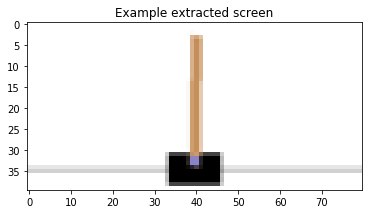

In [5]:
resize = T.Compose([T.ToPILImage(),
                   T.Resize(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

# Gym 코드 기반
screen_width = 600

def get_cart_location():
    '''카트의 중간을 리턴하는 함수'''
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    # Torch의 이미지 텐서에 맞게 transpose (CHW)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # 스크린의 위 아래 부분을 제거 -> screen size: (600, 160)
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    # 스크린의 양 옆 부분을 제거
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # resize 해주고 batch dimension을 추가해준다.
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## 학습
### 하이퍼 파라미터와 유틸리티
이 셀은 모델과 최적화기를 인스턴스화하고 일부 유틸리티를 정의합니다:

- `select_action` - Epsilon Greedy 정책에 따라 행동을 선택합니다. 간단히 말해서, 가끔 모델을 사용하여 행동을 선택하고 때로는 단지 하나를 균일하게 샘플링 할 것입니다. 임의의 액션을 선택할 확률은 `EPS_START` 에서 시작해서 `EPS_END` 를 향해 지수적으로 감소 할 것입니다. `EPS_DECAY`는 감쇠 속도를 제어합니다.

- `plot_durations` - 지난 100개 에피소드의 평균(공식 평가에서 사용 된 수치)에 따른 에피소드의 지속을 도표로 그리기 위한 헬퍼. 도표는 기본 훈련 루프가 포함 된 셀 밑에 있으며, 매 에피소드마다 업데이트됩니다.

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # 모델을 사용해 action 선택
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # 임의로 샘플링(expolation)
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)
    
episode_durations = []

def plot_durations():
    plt.figure()
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100 개의 에피소드 평균을 가져와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001) # 도표가 업데이트 될 수 있도록 잠시 멈춤
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

## 학습 루프
최종적으로 모델 학습을 위한 코드.

여기서, 최적화의 한 단계를 수행하는 `optimize_model` 함수를 찾을 수 있습니다. 먼저 배치 하나를 샘플링하고 모든 Tensor를 하나로 연결하고 $Q(s_t, a_t)$ 와 $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ 를 계산하고 그것들을 손실로 합칩니다. 우리가 설정한 정의를 따르면 만약 $s$ 가 마지막 상태라면 $V(s)=0$ 입니다. 또한 안정성 추가 위한 $V(s_{t+1})$ 계산을 위해 목표 네트워크를 사용합니다. 목표 네트워크는 대부분의 시간 동결 상태로 유지되지만, 가끔 정책 네트워크의 가중치로 업데이트됩니다. 이것은 대개 설정한 스텝 숫자이지만 단순화를 위해 에피소드를 사용합니다.

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043)
    batch = Transition(*zip(*transitions))
    
    # 최종 상태가 아닌 마스크를 계산하고 배치 요소를 연결
    non_final_mask = torch.tensor(tuple(map(lambda s:s is not None, batch.next_state)),
                                 device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                      if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Q(s_t, a) 계산: 모델이 Q(s_t) 를 계산하고, 취한 행동의 칼럼을 선택
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # 모든 다음 상태를 위한 V(s_{t+1}) 계산
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # 기대값 Q 계산
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Huber loss 계산
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # 모델 최적화
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1,1)
    optimizer.step()

아래에서 주요 학습 루프를 찾을 수 있습니다. 처음으로 환경을 재설정하고 `상태` Tensor를 초기화합니다. 그런 다음 행동을 샘플링하고, 그것을 실행하고, 다음 화면과 보상(항상 1)을 관찰하고, 모델을 한 번 최적화합니다. 에피소드가 끝나면 (모델이 실패) 루프를 다시 시작합니다.

아래에서 num_episodes 는 작게 설정됩니다. 노트북을 다운받고 더많은 에피소드를 실행해 보십시오

In [12]:
num_episodes = 50
for i_episode in range(num_episodes):
    # environment, state 초기화
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # 행동 선택과 수행
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        # 새로운 상태 관찰
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        # 메모리에 변이 저장
        memory.push(state, action, next_state, reward)
        
        # 다음 상태로 이동
        state = next_state
        
        # policy network에서 최적화를 한 단계 수행
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # target network 업데이트
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>